<img align="top" width="250" height="70" src="https://s3.amazonaws.com/samples.clarifai.com/logo/clarifai_logo.png" alt="banner">

&nbsp;

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/ps/api-training/uploading/dataframe_uploading.ipynb)

# General Information

This notebook is to be used to upload images using a dataframe to the Clarifai Platform. In this tutorial, you will learn how to use and structure a dataframe to be able to upload images.

## Expected inputs

- The app ID **(required)**
- The user ID **(required)**
- An PAT key token **(required)**

## Limitations

- Not meant for uploading videos
- Not meant for uploading images for object detection


# Table of contents

- [Python requirements](#Python-requirements)
- [Imports](#Imports)
- [Setup Variables](#Setup-Variables)
- [Helper functions (ignore)](<#Helper-functions-(ignore)>)
- [Add Inputs via DataFrame (URLs)](#Add-Inputs-via-DataFrame-(URLs))
- [Add Inputs via DataFrame (local images)](#Add-Inputs-via-DataFrame-(local-images))


# Python requirements

Dependencies:

- clarifai_grpc
- pillow
- pandas
- tqdm
- matplotlib

You can run the following cell to install all three required dependencies. They are required for this notebook.


In [ ]:
%%capture
!pip -q install clarifai-grpc==8.11.0
!pip -q install pillow==9.4.0
!pip -q install tqdm==4.64.1
!pip -q install pandas==1.4.3
!pip -q install matplotlib==3.1.3

Run the following code cell to restart your runtime environment. This is needed to make sure all the libraries are installed properly.

In [ ]:
import os
os.kill(os.getpid(), 9)

**NOTE:** You will get a warning that says that your session has restarted after a crash. That is expected and please proceed to the next code cells.

# Imports

In this section, we will be importing some of the required libraries.


In [2]:
# Standard imports
import re
import os
import sys
import glob
import time
from typing import Any, List, Tuple, Optional, Dict, Iterator, Iterable
from pathlib import Path
import requests
from io import BytesIO
import random

# Imports
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.protobuf.struct_pb2 import Struct
from google.protobuf.json_format import MessageToJson, MessageToDict

# Clarifai imports
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

# Setup Variables

Please fill up the following variables. They are needed to run the notebook.


## Authentication

Please fill the following section with your application PAT key (red), user id (blue) and app id (green). The following picture demonstrates where to find the PAT key (red) and the APP ID (green).



<img src="https://i.imgur.com/v86D8GY.png" alt="drawing" width="600" height="550"/>

<img src="https://i.imgur.com/fx29FyC.png" alt="drawing" width="600" height="550"/>


<img src="https://i.imgur.com/9ZeIieK.png" alt="drawing" width="600" height="550"/>

In [4]:
##################################################################################
# In this section, we set the user authentication, app ID, and the workflow id
# that we will be using for predictions. Change these strings to run your own example.
##################################################################################

# Your user id in portal. You can find it under "profile" settings
USER_ID = "INPUT YOUR USER ID HERE"

# Your API key for your application. Make sure the API scopes have Model, Predict and Workflow enabled
PAT = "INPUT YOUR PERSONAL ACCESS TOKEN HERE"

# Your unique application ID. It should be written on the top left when first entering the application home page
APP_ID = "INPUT YOUR APP ID HERE"

## General Global Variables

Global variables that will be reused throughout the notebook. The channel, stub and metadata will be used to call the Clarifai API.

In [5]:
# Construct the communications channel and the object stub to call requests on.
channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)
metadata = (("authorization", "Key " + PAT),)

# The user data object that will be used for all requests when you are using the PAT authentication
# It is not needed if you are calling the API with the API key
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)

# Helper functions (ignore)

This section contains helper functions that simplify and organize the code. You do not have to modify these functions.


In [3]:
def chunker(seq: Iterable, size: int) -> Iterator[Any]:
    """Function that generates chunks of items from a sequence

    Args:
        seq (sequence object): A sequence of items
        size (int): Size of the chunks to generate

    Yields:
        Iterator[Any]: Yield the next chunk of items
    """
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def is_success(response):
    if response.status.code != status_code_pb2.SUCCESS:
        return False
    return True


def is_mixed_success(response):
    if response.status.code != status_code_pb2.MIXED_STATUS:
        return False
    return True


def build_metadata(**kwargs) -> Struct:
    """function that builds a protobuf Struct object for metadata

    Returns:
        protobuf.Struct: protobuf Struct object
    """
    struct = Struct()
    payload = dict(**kwargs)
    struct.update(payload)
    return struct


def local_path_to_image(image_path):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def url_to_image(url):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def calculate_expected_batch_number(inputs: List[Any], batch_size: int) -> int:
    """Function to calculate the expected number of batches

    Args:
        inputs (List[Any]): List of inputs
        batch_size (int): The number of items in the batch

    Returns:
        int: expected batch number
    """
    expected_batch_nums = (
        (len(inputs) // batch_size) if len(inputs) % batch_size == 0 else (len(inputs) // batch_size + 1)
    )
    return expected_batch_nums


def create_subplot_from_df(df):
    df_len = len(df)
    num_rows = 2
    remove_last = False
    if df_len % 2 == 0:
        num_cols = int(df_len / num_rows)
    else:
        remove_last = True
        num_cols = int((df_len + 1) / num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axs = axs.flatten()
    for image_path, concept, ax in zip(df["image_path"], df["concepts"], axs):
        ax.set_axis_off()
        ax.text(
            0.5,
            0.08,
            f"{concept}",
            fontsize=12,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="green", alpha=0.60),
        )
        if os.path.exists(image_path):
            img = local_path_to_image(image_path)
        else:
            img = url_to_image(image_path)
        ax.imshow(img)
    if remove_last:
        fig.delaxes(axs[-1])  # The indexing is zero-based here

    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1)
    plt.show()

In [4]:
def create_input_proto_from_df(
    df_row:pd.Series,
    path_col: str,
    concept_col:str,    
    metadata_cols:List[str],
    negative_concept_col:Optional[str]="negative_concepts",
    allow_duplicate:bool=True,
)-> resources_pb2.Input:
    """Function that creates one input proto object using a dataframe row

    Args:
        df_row (pd.Series): Series representing a row from a DataFrame
        path_col (Optional[str], optional): Column name for the image paths.
        concept_col (Optional[str], optional):  Column name for the concepts. 
        metadata_cols (Optional[List[str]], optional): List of column names to be uploaded as metadata.
        negative_concept_col (Optional[str], optional): Column name for the negative concepts. Defaults to "negative_concepts".
        allow_duplicate (bool, optional): To allow duplicate urls to be uploaded. Defaults to True.

    Returns:
        resources_pb2.Input: Input Protobuf object
    """
    
    concepts = []
    input_metadata = Struct()

    # parse metadata and create metadata struct
    for metadata_col in metadata_cols:
        if metadata_col in df_row.keys():
            input_metadata.update({metadata_col: str(df_row[metadata_col])})

    input_metadata.update({"image_name": df_row[path_col].split("/")[-1]})
    input_metadata.update({"image_path": df_row[path_col]})

    # Check if there is a concept column, if so create a concept proto (value=1)
    if concept_col in df_row.keys():
        concept = df_row[concept_col]
        input_metadata.update({"concept": concept})
        if concept != "":
            concept_proto = resources_pb2.Concept(id=concept, name=concept, value=1)
            concepts.append(concept_proto)

    # Check if there is a negative concept column, if so create a negative concept proto (value=0)
    if negative_concept_col in df_row.keys():
        not_concept = df_row[negative_concept_col]
        input_metadata.update({"not_concept": not_concept})
        if not_concept != "":
            concept_proto = resources_pb2.Concept(id=not_concept, name=not_concept, value=0)
            concepts.append(concept_proto)

    # Check if image_path is a local image file, if so, read file as bytes
    if os.path.exists(df_row[path_col]):
        with open(df_row[path_col], "rb") as f:
            file_bytes = f.read()

        # create Input proto using the url or local path + any concepts and metadata
        input_pbf = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(base64=file_bytes, allow_duplicate_url=allow_duplicate),
                concepts=concepts,
                metadata=input_metadata,
            )
        )
    # For the case image_path is a url
    else:
        # create Input proto using the url or local path + any concepts and metadata
        input_pbf = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(url=df_row[path_col], allow_duplicate_url=allow_duplicate),
                concepts=concepts,
                metadata=input_metadata,
            )
        )

    return input_pbf

In [5]:
def create_input_protos_from_df(
    df_chunk: pd.DataFrame,
    path_col:str,
    concept_col: str,
    metadata_cols: List[str],
) -> List[resources_pb2.Input]:
    """Function that creates a list of input proto objects using a dataframe

    Args:
        df_chunk (pd.DataFrame): Dataframe containing the image paths and concepts
        path_col (Optional[str], optional): Column name for the image paths.
        concept_col (Optional[str], optional):  Column name for the concepts.
        metadata_cols (Optional[List[str]], optional): List of column names to be uploaded as metadata.

    Returns:
        List[resources_pb2.Input]: List of Input Protobuf objects
    """
    inputs_pbf_list = []
    # iterate through rows and convert into Input protos
    for idx, df_row in df_chunk.iterrows():
        input_pbf = create_input_proto_from_df(
            df_row=df_row, path_col=path_col, concept_col=concept_col, metadata_cols=metadata_cols
        )
        inputs_pbf_list.append(input_pbf)

    return inputs_pbf_list

In [6]:
def post_inputs_from_df(
    stub: service_pb2_grpc.V2Stub,
    metadata: Tuple[Tuple[str, str], None],
    df_chunk: pd.DataFrame,
    path_col: Optional[str] = "image_path",
    concept_col: Optional[str] = "concepts",
    metadata_cols: Optional[List[str]] = ["metadata"],
):
    """Function that uploads images to Clarifai Platform. It calls the PostInputs endpoint

    Args:
        stub (service_pb2_grpc.V2Stub): _description_
        metadata (Tuple[Tuple[str, str], None]): Metadata needed to authenticate the request
        df_chunk (List[Path]): DataFrame to upload
        path_col (Optional[str], optional): Column name for the image paths. Defaults to "image_path".
        concept_col (Optional[str], optional):  Column name for the concepts. Defaults to "concepts".
        metadata_cols (Optional[List[str]], optional): List of column names to be uploaded as metadata. Defaults to ["metadata"].
    """

    # Create a list of Input protobuf objects
    inputs_pbf_list = create_input_protos_from_df(df_chunk, path_col=path_col, concept_col=concept_col, metadata_cols=metadata_cols)

    # Create the request for the API call
    post_inputs_request = service_pb2.PostInputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        inputs=inputs_pbf_list,
    )

    # For API documentation: https://docs.clarifai.com/api-guide/data/create-get-update-delete#add-inputs-via-bytes:~:text=client%20installation%20page.-,Add,-Inputs%E2%80%8B
    post_inputs_response = stub.PostInputs(post_inputs_request, metadata=metadata)

    # If API call fails, retrieve information about the failed inputs
    index_list = []
    failed_inputs = []
    if post_inputs_response.status.code != status_code_pb2.SUCCESS:
        print("There was an error with your request!")

        # Get all inputs status code
        input_status_list = [input.status.code for input in post_inputs_response.inputs]

        # Find all inputs and their index that have failed upload
        for idx, input_status in enumerate(input_status_list):
            if input_status != status_code_pb2.INPUT_DOWNLOAD_PENDING:
                index_list.append(idx)

        # Generate failure information for the failed inputs
        for idx in index_list:
            # Get path name from original image sub list
            inp_path = df_chunk["image_path"][idx]
            print(f"There was an error with uploading {inp_path}")

            # Get input that failed
            input = post_inputs_response.inputs[idx]

            # Get input relevant information
            inp_id = input.id
            inp_status = input.status.code
            inp_details = input.status.details
            failed_inputs.append(
                {"input_id": inp_id, "path": inp_path, "status": inp_status, "details": inp_details}
            )
    return failed_inputs

# Add Inputs via DataFrame (URLs)


## Download CSV File

First let's download the csv file that we will be using.


In [17]:
!mkdir -p ./data
!wget -q -O ./data/test_df.csv https://s3.amazonaws.com/samples.clarifai.com/api-training/test_df.csv

## Prepare

Let's prepare and view the dataframe what we will be uploading.


In [11]:
DATA_DIR = Path("./data")
TEST_DATA_PATH = DATA_DIR / "test_df.csv"

In [12]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df

,image_path,concepts,extension,random_text
0,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random1
1,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random2
2,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random3
3,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random4
4,https://s3.amazonaws.com/samples.clarifai.com/...,both,.jpg,random5
5,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random6
6,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random7


In [13]:
test_df.shape

(7, 4)

We have 7 images with 4 columns. There is the `image_path`, the `concepts` and two additional columns that will be used as **metadata**.

Let's prepare our metadata columns that will be uploaded with the images. In this case, the only columns are `extensions` and `random_text`.


In [14]:
METADATA_COLS = test_df.columns[2:].to_list()
METADATA_COLS

['extension', 'random_text']

## View Images

Now that we have the dataframe ready, we can view some images of the images.


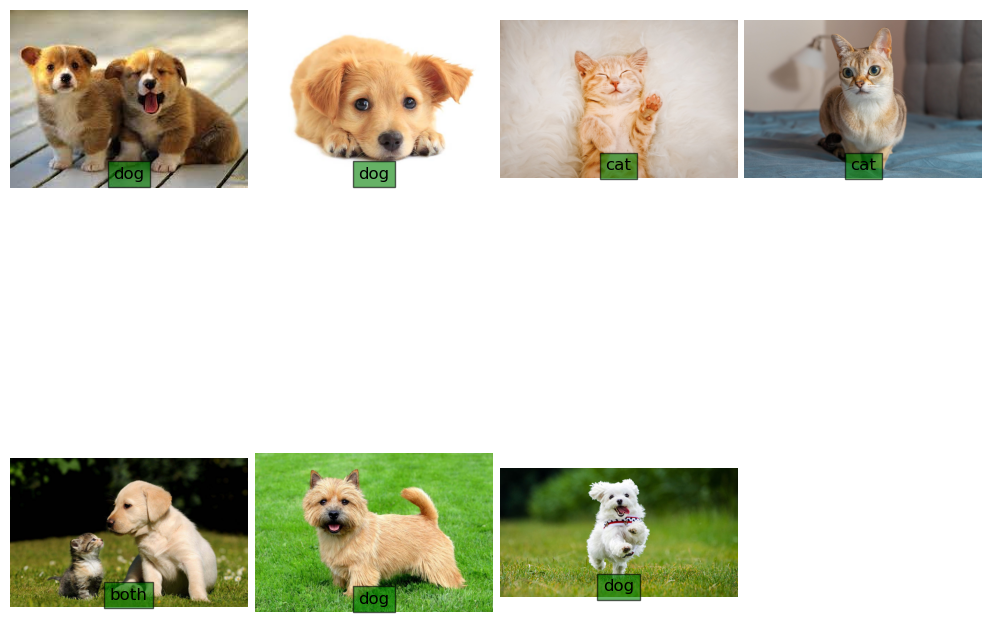

In [15]:
create_subplot_from_df(test_df)

Purrfect.


## Upload

Now we will upload the images using the URLs provided in the dataframe (`test_df["image_path"]`).


In [20]:
# Set batch size to two. For larger datasets, you can increase the batch size to 4-16
batch_size = 2

# Calculate the number of expected batches
expected_batch_nums = calculate_expected_batch_number(test_df, batch_size)

all_failed_inputs = []

# Create a chunker to iterate through the dataframe in batches
for df_chunk in tqdm(chunker(test_df, batch_size), total=expected_batch_nums, desc="Uploading Images"):
    # Upload the batch of images
    failed_inputs = post_inputs_from_df(stub, metadata, df_chunk, metadata_cols=METADATA_COLS)
    all_failed_inputs.extend(failed_inputs)

# Check if any inputs failed to upload
if len(all_failed_inputs) > 0:
    df_failed = pd.DataFrame(all_failed_inputs, columns=["input_id", "url", "status", "details"])
    df_failed.to_csv("failed_inputs.csv", index=False)
    print("Saving failed inputs to failed_inputs.csv")
    
print("Done!")

Uploading Images:   0%|          | 0/4 [00:00<?, ?it/s]

Done!


# Add Inputs via DataFrame (local images)


## Download Image

First let's download a test image from the internet.


In [1]:
!mkdir -p ./data

!wget -q -O ./data/test_image_1.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_1.jpg
!wget -q -O ./data/test_image_2.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_2.jpg
!wget -q -O ./data/test_image_3.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_3.jpg
!wget -q -O ./data/test_image_4.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_4.jpg
!wget -q -O ./data/test_image_5.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_5.jpg
!wget -q -O ./data/test_image_6.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_6.jpg

## Getting Image Paths

Here we will be getting all local paths to the downloaded images.


In [7]:
DATA_DIR = Path("./data/")
file_types = ("*.jpg", "*.jpeg", "*.tiff", "*.png")  # Add more extensions if needed

IMAGE_PATHS = []
for file_type in file_types:
    IMAGE_PATHS.extend(glob.glob(str(DATA_DIR / file_type)))

IMAGE_PATHS = [image_path for image_path in IMAGE_PATHS]
len(IMAGE_PATHS)

6

Let's check to see if the paths are correct. We are expecting 6 images under the `/data/` directory.


In [8]:
IMAGE_PATHS

['data/test_image_3.jpg',
 'data/test_image_2.jpg',
 'data/test_image_1.jpg',
 'data/test_image_5.jpg',
 'data/test_image_4.jpg',
 'data/test_image_6.jpg']

## Prepare Dataframe

Let's prepare the concepts for each image.


In [9]:
concept_list = ["cat", "cat", "dog", "dog", "both", "dog"]
concept_list

['cat', 'cat', 'dog', 'dog', 'both', 'dog']

Let's create dummy metadata for each of the inputs (should be 6).


In [10]:
extension_list = [Path(image_path).suffix for image_path in IMAGE_PATHS]
extension_list

['.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg']

In [11]:
random_text_list = [f"random_{str(image_path).split('_')[-1]}" for image_path in IMAGE_PATHS]
random_text_list

['random_3.jpg',
 'random_2.jpg',
 'random_1.jpg',
 'random_5.jpg',
 'random_4.jpg',
 'random_6.jpg']

Now, we can create the DataFrame object.

In [12]:
test_df = pd.DataFrame(
    {
        "image_path": IMAGE_PATHS,
        "concepts": concept_list,
        "extension": extension_list,
        "random_text": random_text_list,
    }
)
test_df

,image_path,concepts,extension,random_text
0,data/test_image_3.jpg,cat,.jpg,random_3.jpg
1,data/test_image_2.jpg,cat,.jpg,random_2.jpg
2,data/test_image_1.jpg,dog,.jpg,random_1.jpg
3,data/test_image_5.jpg,dog,.jpg,random_5.jpg
4,data/test_image_4.jpg,both,.jpg,random_4.jpg
5,data/test_image_6.jpg,dog,.jpg,random_6.jpg


We have 6 images with 4 columns. There is the `image_path`, the `concepts` and two additional columns that will be used as **metadata**.

Let's prepare our metadata columns that will be uploaded with the images. In this case, the only columns are `extensions` and `random_text`.


## View Images

Now that it is downloaded, we can view the image


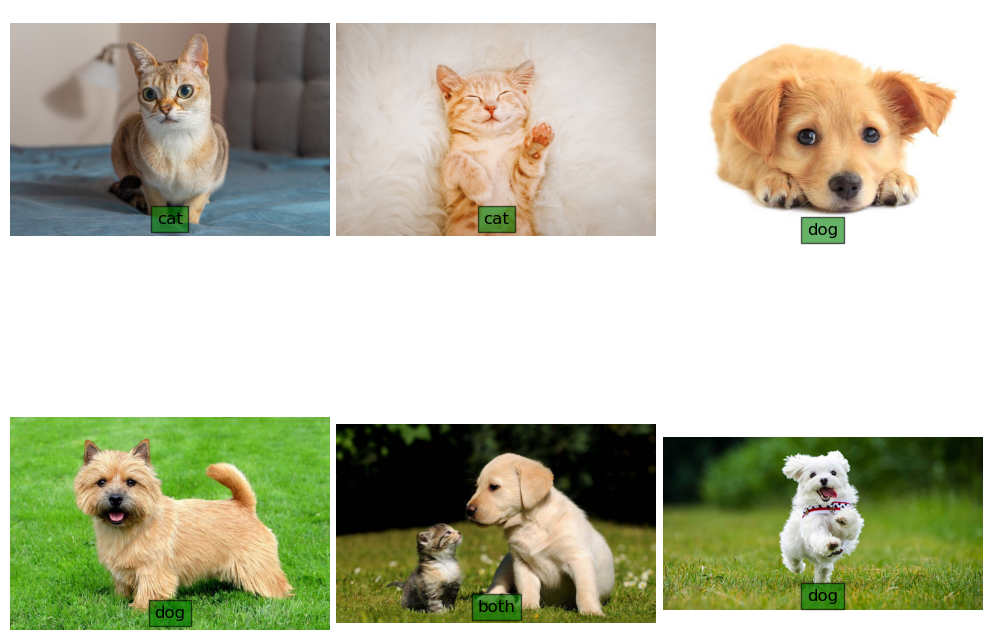

In [13]:
create_subplot_from_df(test_df)

## Upload

Now we will upload the images using the local paths provided in the dataframe (`test_df["image_path"]`).


In [30]:
# Set batch size to two. For larger datasets, you can increase the batch size to 4-16
batch_size = 2

# Calculate the number of expected batches
expected_batch_nums = calculate_expected_batch_number(test_df, batch_size)

all_failed_inputs = []
# Create a chunker to iterate through the dataframe in batches
for df_chunk in tqdm(
    chunker(test_df, batch_size), total=expected_batch_nums, desc="Uploading Images"
):
    # Upload the batch of images
    failed_inputs = post_inputs_from_df(stub, metadata, df_chunk, metadata_cols= METADATA_COLS)
    all_failed_inputs.extend(failed_inputs)

# Check if any inputs failed to upload
if len(all_failed_inputs) > 0:
    df_failed = pd.DataFrame(all_failed_inputs, columns=["input_id", "url", "status", "details"])
    df_failed.to_csv("failed_inputs.csv", index=False)
    print("Saving failed inputs to failed_inputs.csv")

print("Done!")

Uploading Images:   0%|          | 0/3 [00:00<?, ?it/s]

Done!
